# Notebook desenvolvido para classificação de imagens de Raio-X de pulmão utilizando CNN

In [31]:
#Bibliotecas iniciais

import numpy as np
import pandas as pd
import kerastuner as kt
import tensorflow as tf
import matplotlib
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras.models import Sequential, Model
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers,preprocessing
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from tensorflow.keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.optimizers import SGD, RMSprop
from sklearn.metrics import confusion_matrix
import cv2, os, gc, glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical, np_utils
from keras.layers import Conv2D, MaxPool2D
from random import randint

In [2]:
#Verificação da correta configuração do uso de GPU

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11649974901486332470
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 647718246877821819
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951408640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17647148594075766811
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11807094670114121341
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
#Versão do TensorFlow

print(tf.version)

<module 'tensorflow._api.v2.version' from 'D:\\Anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [4]:
#Definição dos recursos computacionais a serem utilizados

from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [5]:
#Diretório onde as imagens estão disponibilizadas e for para varredura de todas

imagePaths = []
for dirname, _, filenames in os.walk('../Projeto_Pos_IGTI/DatasetProjeto/COVID-19_Radiography_Dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [6]:
#Definição das categorias a serem utilizadas das imagens

Data = []
Target = []
resize = 150

cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(cat[label])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15153/15153 [00:57<00:00, 262.89it/s]


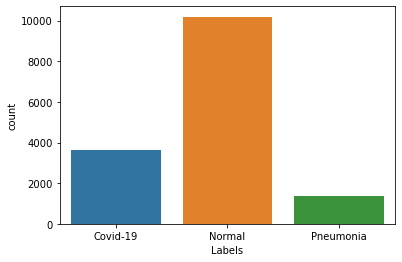

Normal: 10192
Pneumonia:  1345
Covid-19: 3616


In [7]:
#Contabilização por categoria das imagens (Labels)

df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])
plt.show()

print('Normal:',Target.count('Normal'))
print('Pneumonia: ',Target.count('Pneumonia'))
print('Covid-19:',Target.count('Covid-19'))

In [8]:
#Dimensões das imagens do dataset escolhido

size = []
for file in imagePaths: 
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(299, 299)       15013
(299, 299, 3)      140
dtype: int64

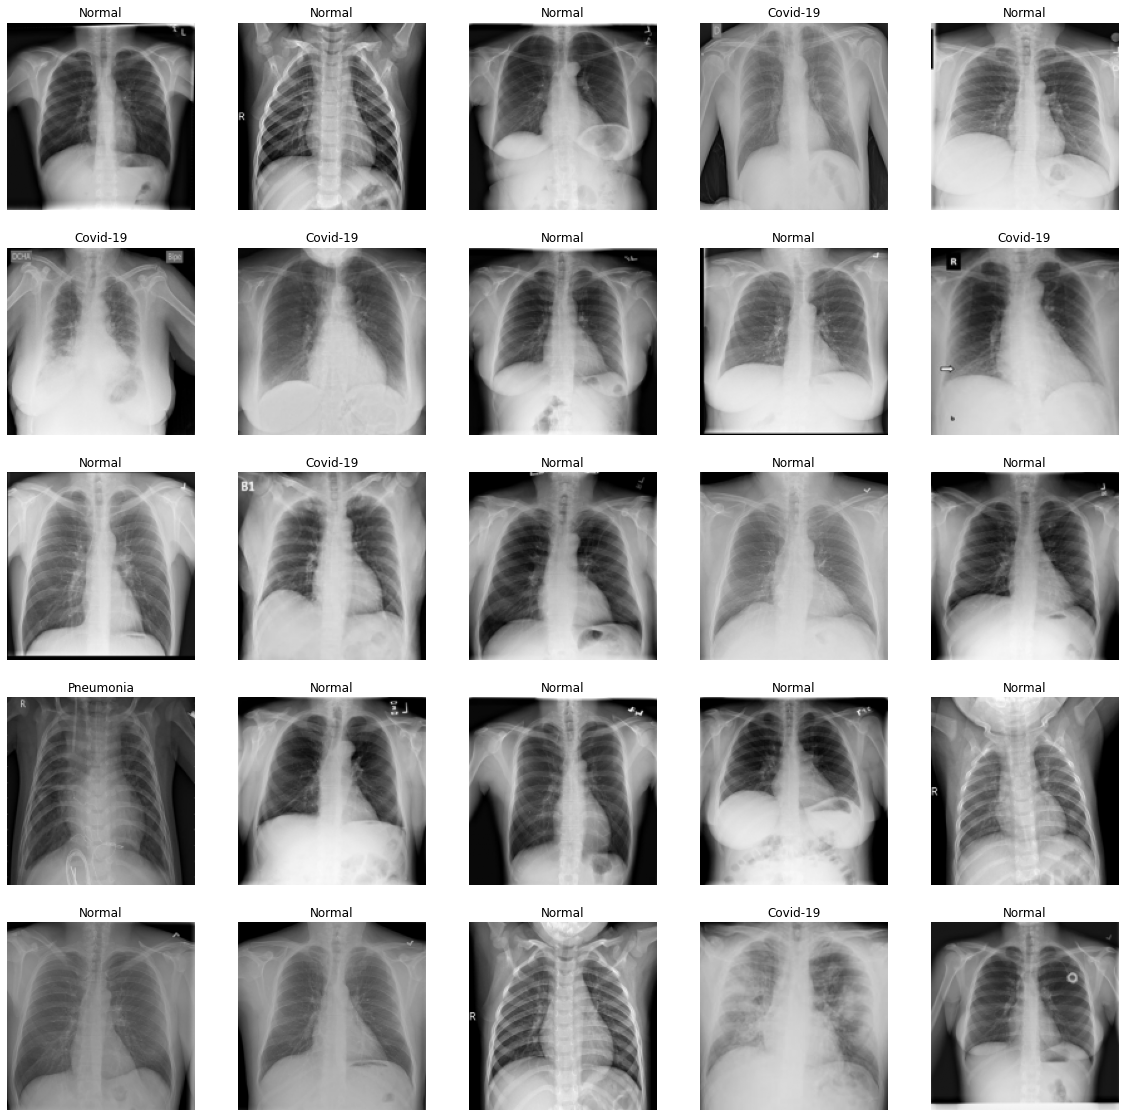

In [9]:
#Mostra as imagens do dataset escolhido

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

In [10]:
#Aplicando encode para as classificações das imagens (Label)

le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Normal' 'Pneumonia']
[1. 0. 0.]


In [11]:
#Separando o dataset em treino e teste

(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=42)

trainX = np.array(x_train)
testX = np.array(x_test)
trainY = np.array(y_train)
testY = np.array(y_test)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(12122, 150, 150, 3)
(3031, 150, 150, 3)
(12122, 3)
(3031, 3)


In [12]:
#Forma de vetor do primeiro registro de treino

trainX[0]

array([[[0.02352941, 0.02352941, 0.02352941],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.00784314, 0.00784314, 0.00784314],
        [0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.        , 0

In [13]:
#Forma de vetor do primeiro registro de treino

trainY[0]

array([1., 0., 0.], dtype=float32)

In [14]:
#Dimensão das imagens

s = 150

In [15]:
# Definição das camadas do modelo que será utilizado (CNN - Convolutional neural network)

model = Sequential()

#Layer 1
model.add(Conv2D(filters = 96, kernel_size =(3,3), input_shape=(s,s,3), kernel_initializer='he_normal'))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))

#Layer 2
model.add(Conv2D(filters = 256, kernel_size =(3,3)))
model.add(BatchNormalization()) 
model.add(Activation('relu')) 
model.add(MaxPool2D(pool_size = (2,2)))

#Layer 3
model.add(Conv2D(filters = 384, kernel_size =(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))

#Layer 4
model.add(Conv2D(filters = 384, kernel_size =(3,3))) 
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Layer 5
model.add(Conv2D(filters = 256, kernel_size =(3,3))) 
model.add(BatchNormalization()) 
model.add(Activation('relu')) 
model.add(MaxPool2D(pool_size=(2, 2)))

#Layer 6
model.add(Flatten()) 
model.add(Dense(1024)) 
model.add(BatchNormalization()) 
model.add(Activation('relu')) 

#Layer 7
model.add(Dense(1024)) 
model.add(BatchNormalization()) 
model.add(Activation('relu')) 
model.add(Dropout(0.5))

#Layer 8
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax"))

In [16]:
#Compila o modelo e define como métrica a acurácia

model.compile(optimizer = keras.optimizers.Adam(),
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])

In [17]:
#Sumário do modelo definido

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 96)      2688      
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 96)      384       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 96)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 256)       221440    
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 256)       0

In [18]:
#Treinamento utilizando o modelo definido e utilizando 30 épocas

epochs = 25

ThisModel = model.fit(trainX, trainY, epochs=epochs, batch_size=40, verbose=1)

Epoch 1/25
304/304 [==============================] - 65s 214ms/step - loss: 0.3752 - accuracy: 0.8475
Epoch 2/25
304/304 [==============================] - 65s 213ms/step - loss: 0.2135 - accuracy: 0.9212
Epoch 3/25
304/304 [==============================] - 61s 201ms/step - loss: 0.1907 - accuracy: 0.9317
Epoch 4/25
304/304 [==============================] - 66s 216ms/step - loss: 0.1365 - accuracy: 0.9507
Epoch 5/25
304/304 [==============================] - 65s 213ms/step - loss: 0.1939 - accuracy: 0.9298
Epoch 6/25
304/304 [==============================] - 59s 194ms/step - loss: 0.1149 - accuracy: 0.9588
Epoch 7/25
304/304 [==============================] - 59s 194ms/step - loss: 0.0969 - accuracy: 0.9662
Epoch 8/25
304/304 [==============================] - 59s 194ms/step - loss: 0.0931 - accuracy: 0.9661
Epoch 9/25
304/304 [==============================] - 60s 197ms/step - loss: 0.0725 - accuracy: 0.9745
Epoch 10/25
304/304 [==============================] - 60s 197ms/step - l

In [19]:
#Avaliação com os dados de teste - obtenção do Loss e da Accuracy

modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))

Test Loss is 0.13416920602321625
Test Accuracy is 0.96304851770401


In [20]:
#Definição das classes e da predição de um dos registros dos dados de teste

class_names = ['COVID-19','Normal','Viral Pneumonia']

y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[1])])

Normal


D:\Anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


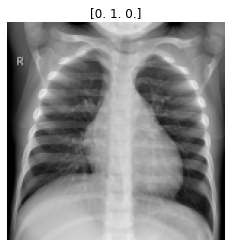

In [21]:
# Imagem do dataset de treino antes da vetorização - o label 1 no meio significa Raio-X Normal
# Utilizada mesma imagem de referência da predição - modelo classificou corretamente a imagem de Raio-X como sendo Normal

plt.figure()
plt.imshow(x_test[1], cmap='gray') 
plt.title(y_test[1])
plt.axis('off') 
plt.show()

In [22]:
#Avaliação do modelo com dados de treino

batch_size=40

predIdxs = model.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.99506   0.97511   0.98499      2893
      Normal    0.99412   0.99608   0.99510      8153
   Pneumonia    0.95975   0.99721   0.97812      1076

    accuracy                        0.99117     12122
   macro avg    0.98298   0.98947   0.98607     12122
weighted avg    0.99130   0.99117   0.99118     12122



In [23]:
#Avaliação do modelo com dados de teste

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.97054   0.91148   0.94009       723
      Normal    0.96901   0.98136   0.97515      2039
   Pneumonia    0.90244   0.96283   0.93165       269

    accuracy                        0.96305      3031
   macro avg    0.94733   0.95189   0.94896      3031
weighted avg    0.96347   0.96305   0.96292      3031



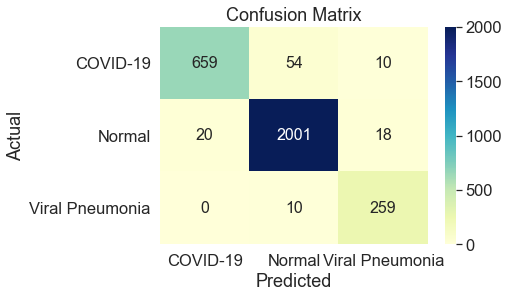

In [24]:
#Matriz de confusão

x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x, index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

dict_keys(['loss', 'accuracy'])


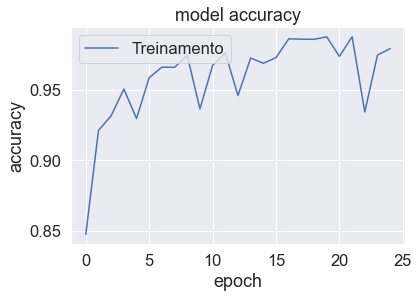

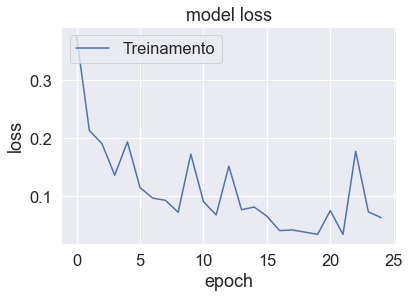

In [25]:
# Lista os dados históricos do treinamento

print(ThisModel.history.keys())

# History para o model accuracy

plt.plot(ThisModel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Treinamento', 'Teste'], loc='upper left')
plt.show()

# History para o model loss

plt.plot(ThisModel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Treinamento', 'Teste'], loc='upper left')
plt.show()


In [26]:
model.save('CNN_Covid19_Xray_V4.h5') 

In [33]:
def get_classlabel(class_code):
    labels = {0:'Covid-19', 1:'Normal', 2:'Pneumonia'}
    
    return labels[class_code]

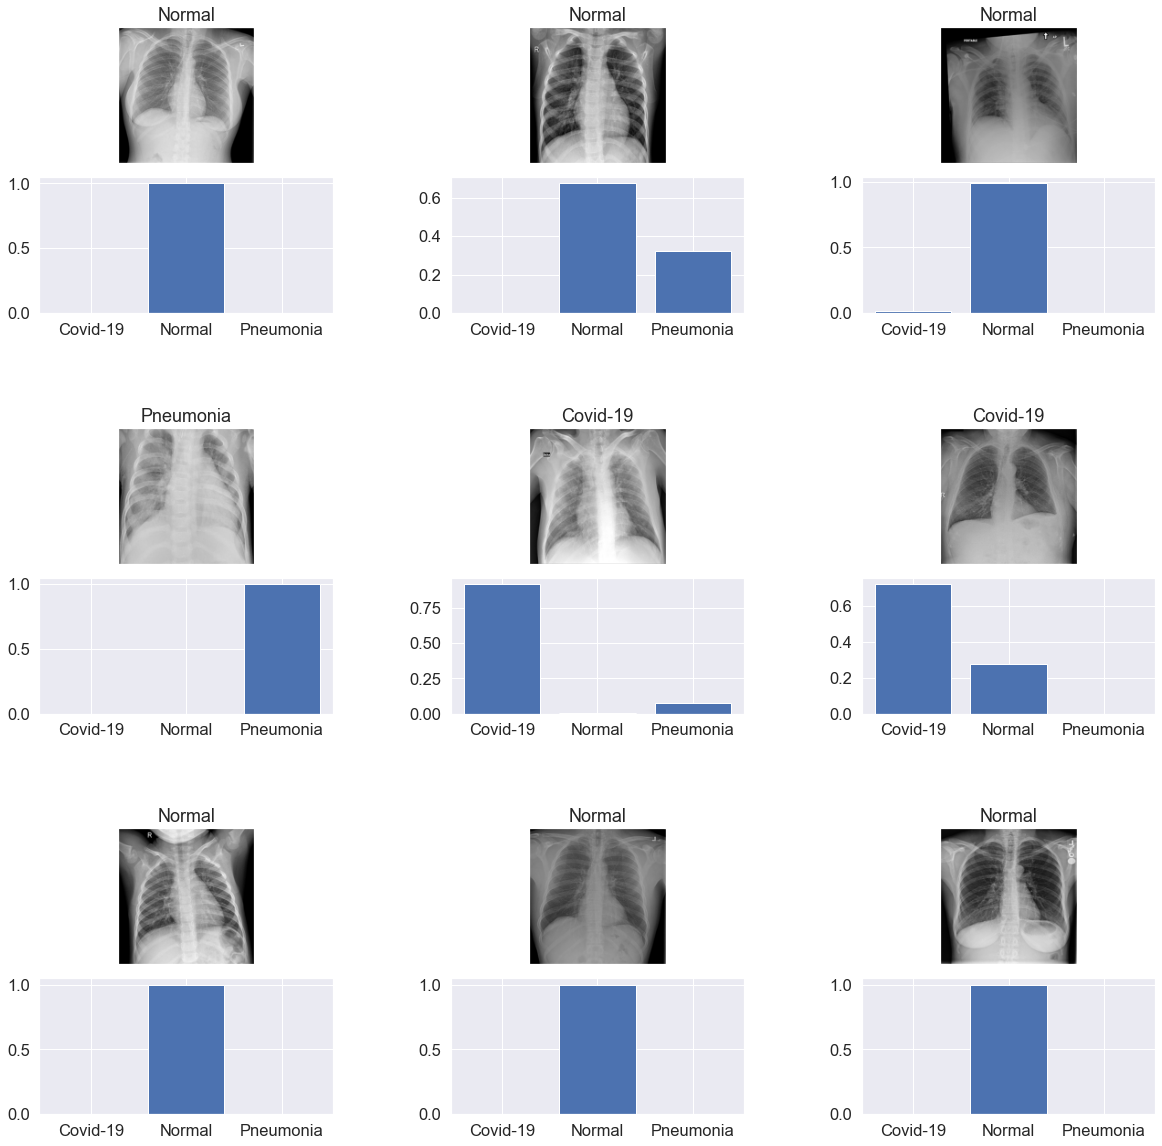

In [36]:
# Avaliação complementar dos resultados

model.load_weights('CNN_Covid19_Xray_V4.h5')

pred_images = testX

fig = plt.figure(figsize=(20, 20))
outer = matplotlib.gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.4)

for i in range(9):
    inner = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(3)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([get_classlabel(0),get_classlabel(1),get_classlabel(2)],pred_prob)
            fig.add_subplot(ax)

plt.show()